# ECCOv4r3
Load files into single xarray dataset

In [2]:
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from xmitgcm import open_mdsdataset
import xgcm

In [3]:
xr.__version__

'0.10.4'

## Load datasets
**Note**: Model output is saved into files with 4 different prefixes depending on whether the variable is averaged (`ave`) or a snapshot (`snp`) and whether it is 2D or 3D. Reference date and time step are defined to get appropriate time points. ECCOv4r3 solution has been run from 1992 to 2015.

In [3]:
ds_ave = open_mdsdataset('/rigel/ocp/users/jt2796/MITgcm/mysetups/ECCO_v4_r3/run/',
                         delta_t=3600, ref_date='1991-12-15 12:0:0', geometry='llc',
                         prefix=['monave2d','monave3d'])

/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xmitgcm-0.2.1-py2.7.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jt2796/miniconda/envs/default/lib/python2.7/site-packages/xmitgcm-0.2.1-py2.7.egg/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [4]:
ds_snp = open_mdsdataset('/rigel/ocp/users/jt2796/MITgcm/mysetups/ECCO_v4_r3/run/',
                         delta_t=3600, ref_date='1992-1-1 12:0:0', geometry='llc',
                         prefix=['monsnp2d','monsnp3d'])

### Geothermal flux

In [5]:
geoflx = np.fromfile('/rigel/ocp/users/jt2796/ECCO_v4_r2/geothermalFlux.bin', dtype=np.float32)

**Note**: Geothermal flux dataset needs to be saved as an xarray data array with the same format as the model output. In order to reformat the loaded data array the byte-ordering needs to be changed.

In [6]:
# Data and type endianness don't match. Change data to match dtype and reshape to 1d
geoflx = geoflx.byteswap().reshape([105300,1])

In [7]:
# Reshape data for each face and save as xarray data array in LLC format
geoflx00 = xr.DataArray(geoflx[:8100,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx01 = xr.DataArray(geoflx[8100:16200,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx02 = xr.DataArray(geoflx[16200:24300,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx03 = xr.DataArray(geoflx[24300:32400,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx04 = xr.DataArray(geoflx[32400:40500,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx05 = xr.DataArray(geoflx[40500:48600,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])
geoflx06 = xr.DataArray(geoflx[48600:56700,0].reshape([90,90]),coords=[np.arange(0,90,1),np.arange(0,90,1)],
                        dims=['j','i'])

geoflx0709 = geoflx[56700:81000,0].reshape([90,270])
geoflx07 = xr.DataArray(geoflx0709[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx08 = xr.DataArray(geoflx0709[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx09 = xr.DataArray(geoflx0709[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

geoflx1012 = geoflx[81000:,0].reshape([90,270])
geoflx10 = xr.DataArray(geoflx1012[:,:90],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx11 = xr.DataArray(geoflx1012[:,90:180],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])
geoflx12 = xr.DataArray(geoflx1012[:,180:],coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

In [8]:
geoflx_llc = xr.concat([geoflx00,geoflx01,geoflx02,geoflx03,geoflx04,geoflx05,geoflx06,
                        geoflx07,geoflx08,geoflx09,geoflx10,geoflx11,geoflx12], 'face')

## Merge dataset of monthly mean and snapshots
- Merge the two datasets to put everything into one single dataset
- Use `time_cnt` for all the fields in `ds_ave`
- Use `time_bnd` for all the fields in `ds_snp`
- Add `geoflx_llc` as `GEOFLX (face, j, i)`

In [9]:
ds = xr.merge([ds_ave,
               geoflx_llc.to_dataset(name='GEOFLX'),
               ds_snp.rename({'time':'time_snp','iter':'iter_snp',
                              'ETAN':'ETAN_snp', 'THETA':'THETA_snp', 'SALT':'SALT_snp'})])

In [10]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 9

In [11]:
# chunk size
(4*50*13*90*90)/1e6

21.06

In [12]:
ds.THETA.encoding

{'dtype': dtype('float32')}

In [13]:
# Size (GB)
ds.nbytes/1e9

134.190544604

In [14]:
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [15]:
grid = xgcm.Grid(ds)
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
Z Axis (periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center
T Axis (periodic):
  * center   time (288) --> inner
  * inner    time_snp (287) --> center

## Output the data to zarr format

In [16]:
with ProgressBar():
    ds.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_output')

[########################################] | 100% Completed |  7hr 10min 28.7s


In [4]:
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_output')

In [5]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

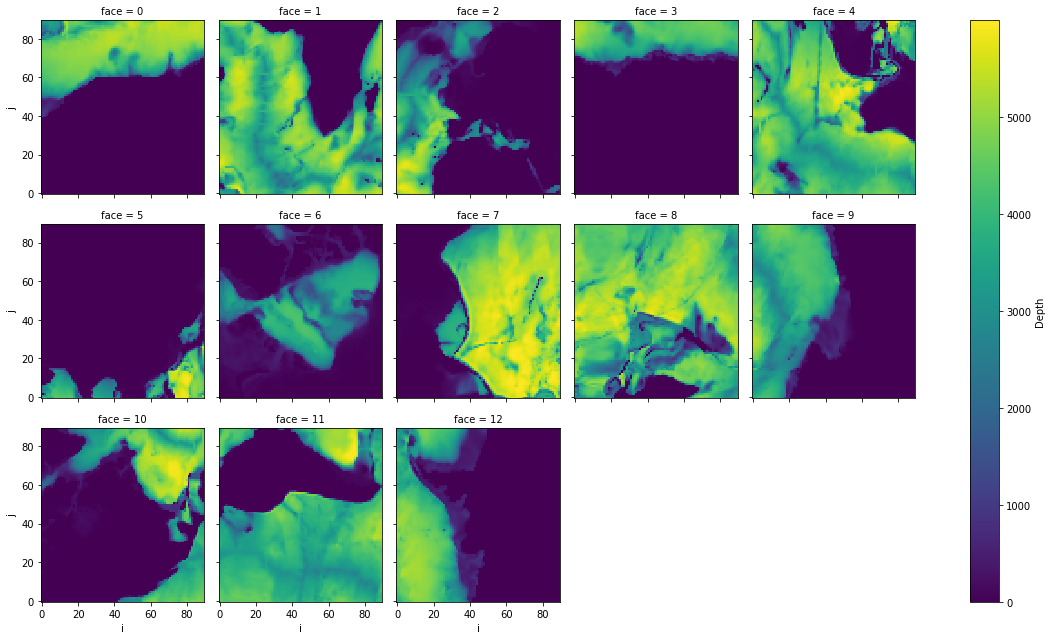

In [7]:
plt.figure(figsize=(14,10))
ds.Depth.plot(col='face', col_wrap=5)